In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import *
import matplotlib.pyplot as plt

In [2]:
with open("../DATA/training_data.csv") as f:
    lines = (line for line in f if not line.startswith('#'))
    data = np.loadtxt(lines, delimiter=',', skiprows=1)

In [3]:
# initial time value
t0 = data[0, 0]

# time array
t = data[:, 0]
t_orig = t.copy()
nt = t.shape[0]

# index where to stop taking the snapshots (first current value)
t_lim = np.where(np.isclose(t, t.max()))[0][0]

# Snapshots -- Taking different parameters as dofs (9 parameters)

X = data[:, 2].reshape((-1, t_lim+1))
#X = data[:, 2].reshape((-1, nt))[:, :t_lim+1]
nt = t_lim + 1
t = t[:nt]

In [4]:
# DMD Learning

dt = t[-1]-t[-2]
dmd = DMD()
rom = ROM(dmd)
rom.decompose(X[:, :-1], Y=X[:, 1::], dt = dt, rank = 0, sorting="real", center=True)

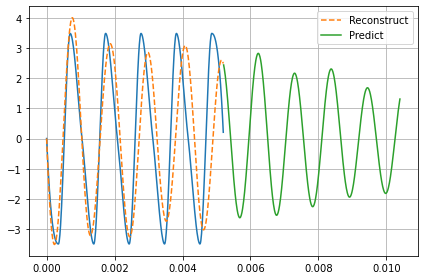

In [5]:
# DMD Prediction
pred_coeff = 2
t_predict = np.concatenate((t, np.linspace(t[-1] + dt, pred_coeff *t[-1], nt)))
dof_id = 0

prediction = np.real(rom.predict(t_predict,))
reconstr_cutoff = int((1/pred_coeff)*t_predict.shape[0])

plt.plot(t, X[dof_id, :]);
plt.plot(t_predict[:reconstr_cutoff], prediction[dof_id, :reconstr_cutoff], '--', label = 'Reconstruct');
plt.plot(t_predict[reconstr_cutoff::], prediction[dof_id, reconstr_cutoff::], label = 'Predict');
plt.grid();
plt.legend();
plt.tight_layout();

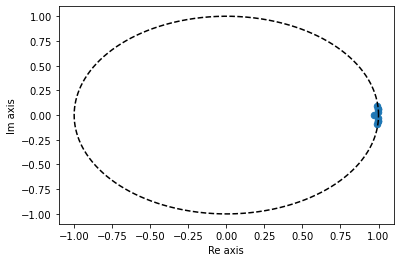

In [6]:
plt.plot(np.real(rom.model.lambd), np.imag(rom.model.lambd), '.', markersize = 13);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

## High order DMD on only one dof (One parameter)

In [7]:
start = 1
X = data[:, 2].reshape((-1, t_lim+1))[0, :].reshape((1, -1))[:, start::]
t = data[:, 0]
t = t[:nt]
t = t[start::]

In [8]:
# HoDMD Learning

dt = t[-1]-t[-2]
hodmd = HODMD()
rom = ROM(hodmd)
rom.decompose(X[:, :-1], Y=X[:, 1::], dt = dt, hod = 60,)

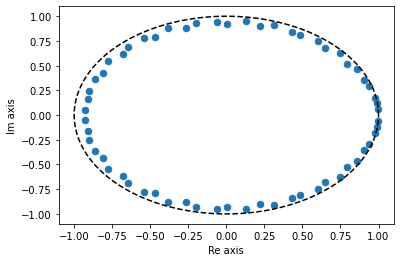

In [9]:
plt.plot(np.real(rom.model.lambd), np.imag(rom.model.lambd), '.', markersize = 13);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

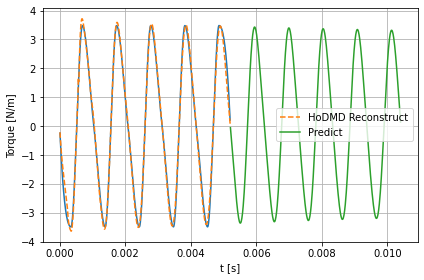

In [10]:
#HoDMD prediction
pred_coeff = 2
t_predict = np.concatenate((t, np.linspace(t[-1] + dt, pred_coeff *t[-1], nt)))

prediction = np.real(rom.predict(t_predict,t1 = t[0],))
reconstr_cutoff = int((1/pred_coeff)*t_predict.shape[0])

plt.plot(t, X[0, :]);
plt.plot(t_predict[:reconstr_cutoff], prediction[0, :reconstr_cutoff], '--', label = 'HoDMD Reconstruct');
plt.plot(t_predict[reconstr_cutoff::], prediction[0, reconstr_cutoff::], label = 'Predict');
plt.grid();
plt.legend();
plt.xlabel("t [s]")
plt.ylabel("Torque [N/m]")
plt.tight_layout();

**Comparison with DMD**

In [11]:
# DMD Learning

dt = t[-1]-t[-2]
dmd = DMD()
rom = ROM(dmd)
rom.decompose(X[:, :-1], Y=X[:, 1::], dt = dt,)

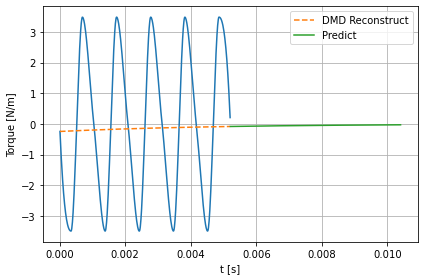

In [12]:
#DMD prediction
pred_coeff = 2
t_predict = np.concatenate((t, np.linspace(t[-1] + dt, pred_coeff *t[-1], nt)))

prediction = np.real(rom.predict(t_predict,t1 = t[0],))
reconstr_cutoff = int((1/pred_coeff)*t_predict.shape[0])

plt.plot(t, X[0, :]);
plt.plot(t_predict[:reconstr_cutoff], prediction[0, :reconstr_cutoff], '--', label = 'DMD Reconstruct');
plt.plot(t_predict[reconstr_cutoff::], prediction[0, reconstr_cutoff::], label = 'Predict');
plt.grid();
plt.legend();
plt.xlabel("t [s]")
plt.ylabel("Torque [N/m]")
plt.tight_layout();

**Interpolation on $\mu = current$**

In [13]:
kdmd = KERDMD()
krom = ROM(kdmd)
krom.decompose(X=X[:, :-1], Y=X[:, 1::], dt=dt, p=3, normalize=True, center=True)

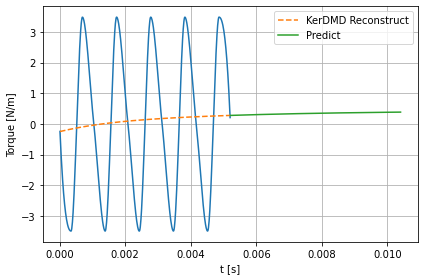

In [14]:
#KerDMD prediction
pred_coeff = 2
t_predict = np.concatenate((t, np.linspace(t[-1] + dt, pred_coeff *t[-1], nt)))

prediction = np.real(krom.predict(t_predict,t1 = t[0],))
reconstr_cutoff = int((1/pred_coeff)*t_predict.shape[0])

plt.plot(t, X[0, :]);
plt.plot(t_predict[:reconstr_cutoff], prediction[0, :reconstr_cutoff], '--', label = 'KerDMD Reconstruct');
plt.plot(t_predict[reconstr_cutoff::], prediction[0, reconstr_cutoff::], label = 'Predict');
plt.grid();
plt.legend();
plt.xlabel("t [s]")
plt.ylabel("Torque [N/m]")
plt.tight_layout();

In [15]:
nx = 1
m = nt
p = len(np.where(np.isclose(data[:, 0], t.max()))[0])
param_data = data[:, 2].reshape((p, 1, m))
param = np.unique(data[:, 1])

In [16]:
pard = ParDMD()
muROM = ParROM(pard)

muROM.decompose(X = param_data, params = param, dt = dt, normalize = True, dmd_model="hodmd", hod=104)

**We test for current = 375**

In [17]:
test_curr = 375

result_ = np.real(muROM.predict(t_predict, test_curr, t1 = t0, stabilize=False))

/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/rom_am/hodmd.py:108: UserWarning: The method 2 is the only one suppported for HoDMD, It will be used here.
  warnings.warn(


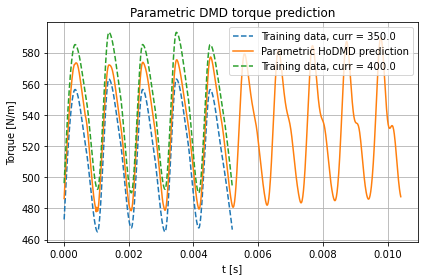

In [18]:
plt.plot(t, param_data[7, 0, 1::], '--', label = "Training data, curr = "+str(param[7]))
plt.plot(t_predict, result_[0, :], label = "Parametric HoDMD prediction")
plt.plot(t, param_data[8, 0, 1::], '--', label = "Training data, curr = "+str(param[8]))
plt.grid();
plt.legend();
plt.xlabel("t [s]");
plt.ylabel("Torque [N/m]");
plt.title("Parametric DMD torque prediction");
plt.tight_layout();